In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Catboost

In [13]:
df = pd.read_csv('data/final_data_for_modelling.csv')
df.drop(columns=[ "Neighbourhood", "showed"] , inplace=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106980 entries, 0 to 106979
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   gender                                      106980 non-null  object 
 1   age                                         106980 non-null  int64  
 2   neighbourhood                               106980 non-null  object 
 3   scholarship                                 106980 non-null  int64  
 4   hypertension                                106980 non-null  int64  
 5   diabetes                                    106980 non-null  int64  
 6   alcoholism                                  106980 non-null  int64  
 7   handicap                                    106980 non-null  int64  
 8   sms_received                                106980 non-null  int64  
 9   days_between_appointment_and_scheduled_day  106980 non-null  int64  
 

In [14]:
# Splitting dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["no_show"]), df["no_show"], random_state=0,test_size=0.2)


In [15]:
df.columns

Index(['gender', 'age', 'neighbourhood', 'scholarship', 'hypertension',
       'diabetes', 'alcoholism', 'handicap', 'sms_received',
       'days_between_appointment_and_scheduled_day', 'age_group',
       'appointment_day_of_week', 'tempmax', 'temp', 'feelslikemax',
       'feelslike', 'humidity', 'windspeed', 'solarradiation', 'solarenergy',
       'uvindex', 'rating', 'no_show', 'previous_app'],
      dtype='object')

In [16]:
cat_features = [0, 2, 7, 10, 11]

In [17]:
from catboost import CatBoostClassifier

In [18]:
clf = CatBoostClassifier()
params = {'iterations': [500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          #'eval_metric': ['recall'],
          'logging_level':['Silent'],
          'random_seed': [0]
         }
grid_search = GridSearchCV(estimator=clf, param_grid=params, scoring="f1", cv=3, verbose=2)
grid_search.fit(X_train, y_train, cat_features=cat_features)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END depth=4, iterations=500, l2_leaf_reg=1e-20, leaf_estimation_iterations=10, logging_level=Silent, loss_function=Logloss, random_seed=0; total time=   7.0s
[CV] END depth=4, iterations=500, l2_leaf_reg=1e-20, leaf_estimation_iterations=10, logging_level=Silent, loss_function=Logloss, random_seed=0; total time=   6.7s
[CV] END depth=4, iterations=500, l2_leaf_reg=1e-20, leaf_estimation_iterations=10, logging_level=Silent, loss_function=Logloss, random_seed=0; total time=   7.6s
[CV] END depth=4, iterations=500, l2_leaf_reg=1e-20, leaf_estimation_iterations=10, logging_level=Silent, loss_function=CrossEntropy, random_seed=0; total time=   7.6s
[CV] END depth=4, iterations=500, l2_leaf_reg=1e-20, leaf_estimation_iterations=10, logging_level=Silent, loss_function=CrossEntropy, random_seed=0; total time=   7.9s
[CV] END depth=4, iterations=500, l2_leaf_reg=1e-20, leaf_estimation_iterations=10, logging_level=Silent, loss_fun

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f80a9833730>,
             param_grid={'depth': [4, 5, 6], 'iterations': [500],
                         'l2_leaf_reg': array([1.00000000e-20, 3.16227766e-20, 1.00000000e-19]),
                         'leaf_estimation_iterations': [10],
                         'logging_level': ['Silent'],
                         'loss_function': ['Logloss', 'CrossEntropy'],
                         'random_seed': [0]},
             scoring='f1', verbose=2)

In [19]:
## Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, cat_features=cat_features)

## Classsification report
y_pred_train = best_model.predict(X_train)
print(f"Train Report")
print(classification_report(y_train, y_pred_train))
y_pred_test = best_model.predict(X_test)
print("Test Report")
print(classification_report(y_test, y_pred_test))

Train Report
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     68230
           1       0.80      0.03      0.06     17354

    accuracy                           0.80     85584
   macro avg       0.80      0.51      0.47     85584
weighted avg       0.80      0.80      0.72     85584

Test Report
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17077
           1       0.57      0.02      0.04      4319

    accuracy                           0.80     21396
   macro avg       0.68      0.51      0.46     21396
weighted avg       0.75      0.80      0.72     21396



In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(y_test, y_test_prob):

    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(thresholds, precision[:-1], color='purple')
    ax.plot(thresholds, recall[:-1], color='green')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision/Recall')
    ax.set_xlabel('Threshold')

    #display plot
    plt.show()

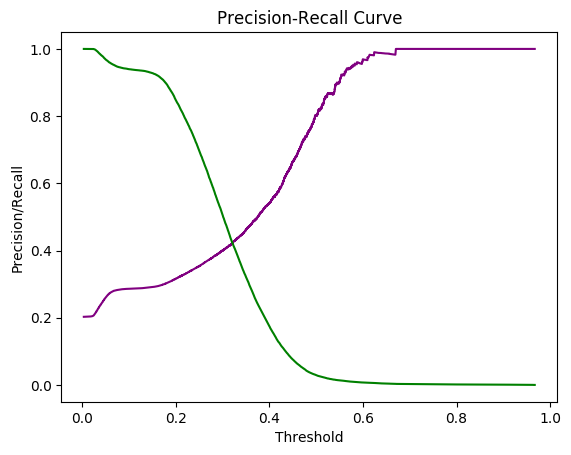

In [21]:
## Plot PR for train data
y_pred_probs = best_model.predict_proba(X_train)
y_pred_probs = y_pred_probs[:, 1]

plot_pr_curve(y_train, y_pred_probs)

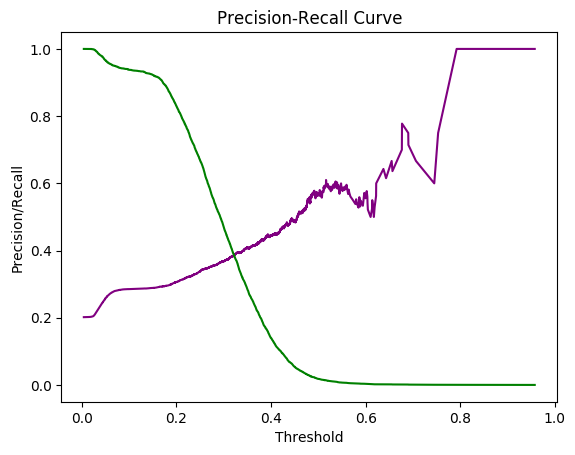

In [22]:
## Plot PR for train data
y_pred_probs = best_model.predict_proba(X_test)
y_pred_probs = y_pred_probs[:, 1]

plot_pr_curve(y_test, y_pred_probs)

In [23]:
importances = best_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances.sort_values(ascending=False)

days_between_appointment_and_scheduled_day    35.747797
age                                            8.438826
previous_app                                   7.875650
neighbourhood                                  6.798223
age_group                                      5.376134
handicap                                       3.726816
appointment_day_of_week                        3.407968
humidity                                       3.332652
windspeed                                      3.038703
scholarship                                    2.012072
alcoholism                                     1.943023
rating                                         1.849031
tempmax                                        1.806063
solarradiation                                 1.781547
feelslike                                      1.773252
solarenergy                                    1.759641
gender                                         1.684009
feelslikemax                                   1